In [13]:
import torch
import torchvision
from torchvision import transforms

model = torchvision.models.segmentation.deeplabv3_resnet101(weights='DeepLabV3_ResNet101_Weights.DEFAULT') 
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', weights='DeepLabV3_ResNet101_Weights.DEFAULT')
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', weights='DeepLabV3_ResNet101_Weights.DEFAULT')
model.eval() #sets model in evaluation mode

filename = "testset/bird.png"

from PIL import Image
input_image = Image.open(filename)
#input_image = input_image.resize([512, 512]) # maybe needed for large images
input_image = input_image.convert("RGB")
print('Input image size: ', input_image.size) 


Input image size:  (512, 512)


In [14]:
# The images have to be loaded in to a range of [0, 1] and then normalized using the following mean and std 
preprocess = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model(adds 1 more dimension to tensor)
#display(input_batch.shape) #[1, 3, 382, 272]

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)  # To get the maximum prediction of each class


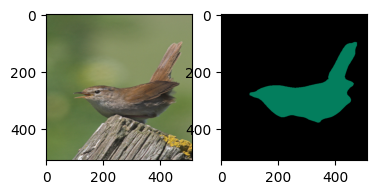

In [15]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.subplot(1, 3, 2)
plt.imshow(r)


In [16]:
'''
aspp_layer = model.classifier[4]
display(aspp_layer)
aspp_features = aspp_layer.weight.data.numpy()
display(aspp_features.shape)
'''
# retrieving aspp layer features 
aspp = torchvision.models.segmentation.deeplabv3.ASPP(in_channels=3, atrous_rates=[6, 12, 18])
aspp.eval()

aspp_features = aspp.forward(input_batch)
#display(aspp_features)
aspp_features = aspp_features.squeeze(0)
display(aspp_features.shape)

torch.Size([256, 512, 512])

In [17]:
import cv2
import numpy as np

def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).numpy()

    # Create Numpy arrays containing zeros.
    # Later to be used to fill them with respective red, green, and blue pixels.
    
    red_map = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map = np.zeros_like(labels).astype(np.uint8)

    for label_num in range(0, len(colors)):
        index = labels == label_num
        
        R, G, B = colors[label_num]

        red_map[index] = R
        green_map[index] = G
        blue_map[index] = B

    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    return segmentation_map


def image_overlay(image, segmented_image):
    alpha = 1   # transparency for the original image
    beta = 0.8  # transparency for the segmentation map
    gamma = 0   # scalar added to each sum

    image = np.array(image)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    
    cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    
    return image
     

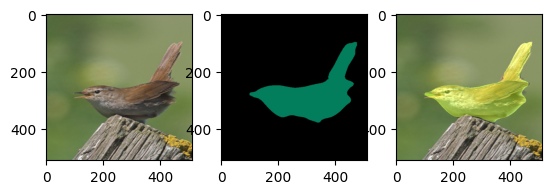

In [18]:
def perform_inference():
    # Get RGB segmentation map
    segmented_image = draw_segmentation_map(output)

    # Resize to original image size
    segmented_image = cv2.resize(segmented_image, input_image.size, cv2.INTER_LINEAR)
    overlayed_image = image_overlay(input_image, segmented_image)

    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.subplot(1, 3, 2)
    plt.imshow(r)
    plt.subplot(1, 3, 3)
    plt.imshow(overlayed_image)
    
    return

perform_inference()